# Pedestrian path Prediction

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


## Libraries

In [ ]:
%matplotlib inline
from collections import defaultdict
import numpy as np # For numerical calculations
import pandas as pd # For handling the data 
import xml.etree.ElementTree as ET # To parse XML files
from statsmodels.tsa.stattools import adfuller # For Dickey-Fuller Stationarity Test
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

import seaborn as sns
import matplotlib.pyplot as plt # For plotting

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, LSTM, Dropout, Masking
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
import math

In [ ]:
plt.rcParams['figure.figsize'] = [15, 7] # For bigger plots
plt.style.use('fivethirtyeight') # Special style template for matplotlib, highly useful for visualizing time series data

## Parsing the XML Files

In [ ]:
network_file_path = '/content/drive/MyDrive/Pedestrian-Neural-Path-Prediction/sumo_pedestrian_simulation/osm.net.xml'
output_file_path = '/content/drive/MyDrive/Pedestrian-Neural-Path-Prediction/sumo_pedestrian_simulation/fcd-output.xml'

Parse the network xml file to obtain the min and max values for x and y

In [ ]:
tree = ET.parse(network_file_path) # Open the network XML file
root = tree.getroot() # Get the root of the file
convBoundary = root[0].attrib['convBoundary'] # Get the convBoundary attribute of the location tag
x_min, y_min, x_max, y_max = map(lambda x: float(x), convBoundary.split(',')) # Get the min and max by splitting the convBoundary stringing
print('X_min = {}, X_max = {}, Y_min = {}, Y_max = {}'.format(x_min, x_max, y_min, y_max))

X_min = 0.0, X_max = 2512.95, Y_min = 0.0, Y_max = 1576.61


Parse the fcd output file to obtain the coordinates of the pedestrians

In [ ]:
# Create an empty dataframe and then fill it up with values from the xml file
columns = ['time', 'id', 'x', 'y', 'angle', 'speed', 'pos', 'edge', 'slope']
output_data = pd.DataFrame(columns=columns)

# Open the XML file
root = ET.parse(output_file_path).getroot()

# Iterate over all timesteps
for timestep in root:
    # Get the time value of the timestep
    time = timestep.attrib
    # Iterate over all pedestrians in a timestep
    rows = []
    for person in timestep:
        rows.append(dict(time, **person.attrib))
    # Append the data to the output_data dataframe
    output_data = output_data.append(rows, ignore_index=True).apply(pd.to_numeric, errors='ignore')


In [ ]:
output_data.to_csv(r'/content/drive/MyDrive/Pedestrian-Neural-Path-Prediction/sumo_pedestrian_simulation/fcd-output.csv')

In [ ]:
print("Number of rows : {}".format(len(output_data.index)))
print(output_data.head(50))

Number of rows : 823316
    time    id        x        y   angle  speed    pos            edge  slope
0    0.0  ped0  1254.41   722.40   85.74   0.00   0.00     389101374#1    0.0
1    1.0  ped0  1255.10   722.09   85.74   0.66   4.34  :4605728249_w0    0.0
2    2.0  ped0  1256.36   722.19   85.56   1.26   3.08  :4605728249_w0    0.0
3    3.0  ped0  1257.81   722.30   85.56   1.46   1.62  :4605728249_w0    0.0
4    4.0  ped0  1259.13   722.40   85.73   1.33   0.29  :4605728249_w0    0.0
5    4.0  ped1  1156.49  1458.43  176.55   0.00   0.00       153698394    0.0
6    5.0  ped1  1156.56  1457.29  176.55   1.15   1.15       153698394    0.0
7    5.0  ped0  1260.60   722.87   85.73   1.46  16.97     389101374#0    0.0
8    6.0  ped1  1156.63  1456.18  176.55   1.11   2.26       153698394    0.0
9    6.0  ped0  1262.04   722.98   85.73   1.40  15.58     389101374#0    0.0
10   7.0  ped1  1156.70  1455.02  176.45   1.16   3.42       153698394    0.0
11   7.0  ped0  1263.33   723.08   85.73

In [ ]:
# Only show statistics for the x and y coordinates
print(output_data.drop(columns=["time", "slope", "edge", "id"]).describe())

                   x              y         angle          speed            pos
count  823316.000000  823316.000000  823316.00000  823316.000000  823316.000000
mean     1134.615730     897.230569     195.87724       1.195903      29.110804
std       449.539235     210.343588      99.11199       0.278795      32.692956
min       203.720000     372.360000       0.00000       0.000000       0.000000
25%       776.610000     707.510000      85.67000       1.120000       4.850000
50%      1108.340000     896.780000     176.26000       1.230000      17.080000
75%      1505.572500    1074.010000     265.58000       1.340000      43.520000
max      2164.240000    1492.760000     359.94000       1.830000     279.950000


In [ ]:
pedestrian_sequence_length = list()
pedestrian = list()
for ped, g in output_data.groupby("id"):
    pedestrian_sequence_length.append(len(g))
    pedestrian.append(ped)

In [ ]:
print("Average pedestrian sequence length: {}".format(np.mean(pedestrian_sequence_length)))

Average pedestrian sequence length: 785.6068702290077


In [ ]:
pedestrian_count = 0
for _, g in output_data.groupby("id"):
    pedestrian_count += 1

In [ ]:
print("Total number of unique pedestrians: {}".format(pedestrian_count))

Total number of unique pedestrians: 1048


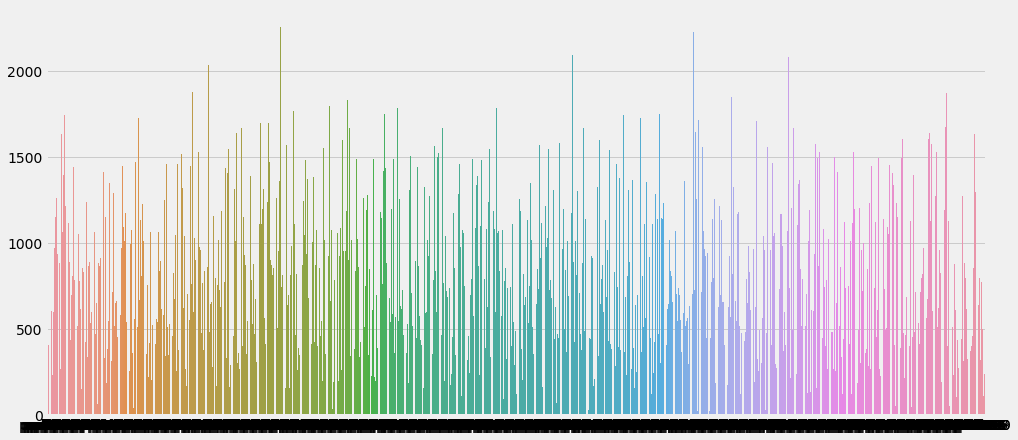

In [ ]:
sns.barplot(x=pedestrian, y=pedestrian_sequence_length)

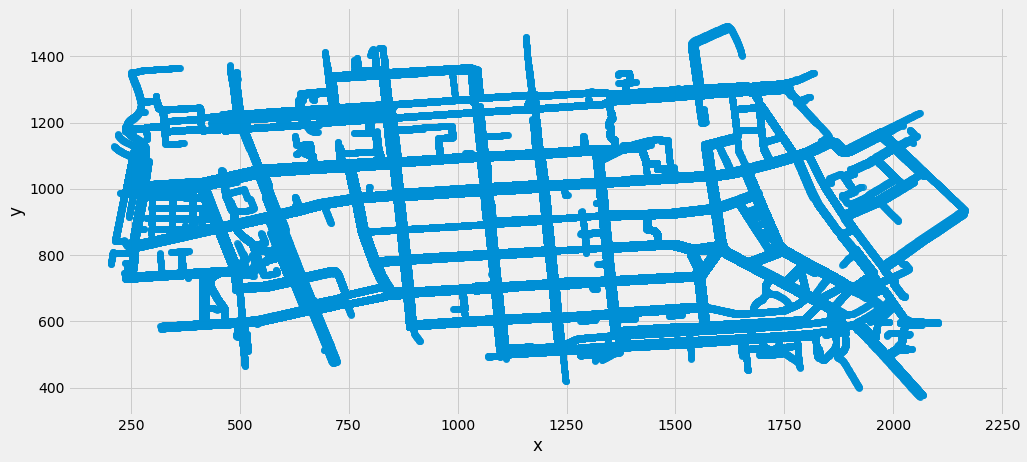

In [ ]:
sns.regplot(x="x", y="y", data=output_data, fit_reg=False)

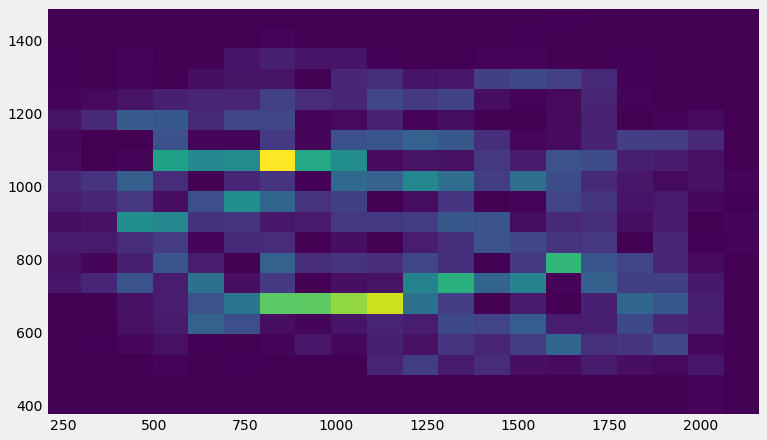

In [ ]:
h, _, _, _ = plt.hist2d(output_data["x"], output_data["y"], bins = 20)
plt.imshow(h, origin = "lower", interpolation = "gaussian")

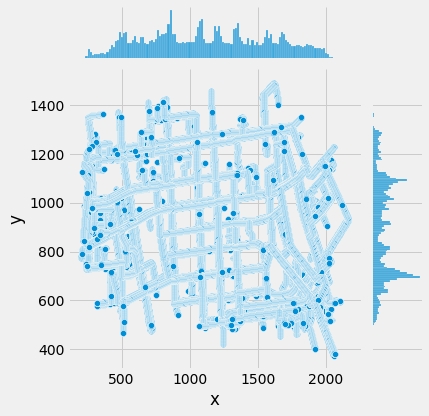

In [ ]:
sns.jointplot(x="x", y="y", data=output_data)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


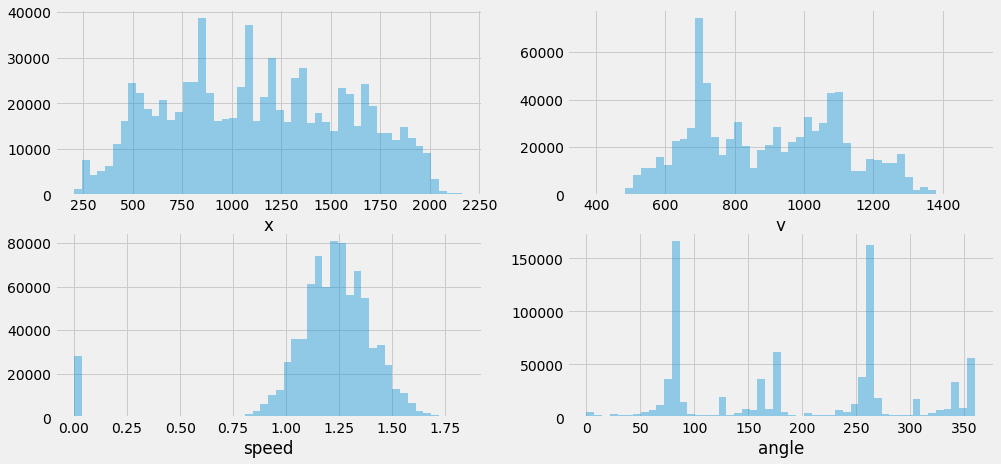

In [ ]:
f, axes = plt.subplots(2, 2)
sns.distplot(output_data["x"], kde=False, ax=axes[0, 0])
sns.distplot(output_data["y"], kde=False, ax=axes[0, 1])
sns.distplot(output_data["speed"], kde=False, ax=axes[1, 0])
sns.distplot(output_data["angle"], kde=False, ax=axes[1, 1])

Treating the data as a time series by considering each pedestrian's path individually

In [ ]:
ped0 = output_data.loc[output_data['id'] == 'ped0'].drop(columns=["slope"]).reset_index(drop=True).copy(deep=True)
print(ped0.head(100))

    time    id        x       y  angle  speed     pos            edge
0    0.0  ped0  1254.41  722.40  85.74   0.00    0.00     389101374#1
1    1.0  ped0  1255.10  722.09  85.74   0.66    4.34  :4605728249_w0
2    2.0  ped0  1256.36  722.19  85.56   1.26    3.08  :4605728249_w0
3    3.0  ped0  1257.81  722.30  85.56   1.46    1.62  :4605728249_w0
4    4.0  ped0  1259.13  722.40  85.73   1.33    0.29  :4605728249_w0
..   ...   ...      ...     ...    ...    ...     ...             ...
95  95.0  ped0  1380.49  728.35  85.82   1.41  166.73     -23755961#2
96  96.0  ped0  1381.90  728.46  85.82   1.42  165.31     -23755961#2
97  97.0  ped0  1383.36  728.56  85.82   1.46  163.85     -23755961#2
98  98.0  ped0  1384.65  728.66  85.82   1.30  162.55     -23755961#2
99  99.0  ped0  1386.07  728.76  85.82   1.42  161.13     -23755961#2

[100 rows x 8 columns]


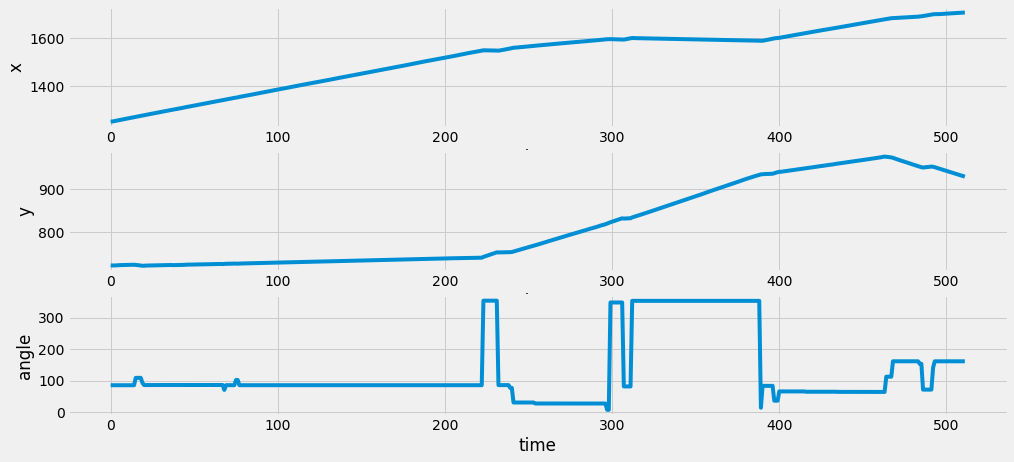

In [ ]:
f, axes = plt.subplots(3, 1)
sns.lineplot(x="time", y="x", data=ped0, ax=axes[0])
sns.lineplot(x="time", y="y", data=ped0, ax=axes[1])
sns.lineplot(x="time", y="angle", data=ped0, ax=axes[2])

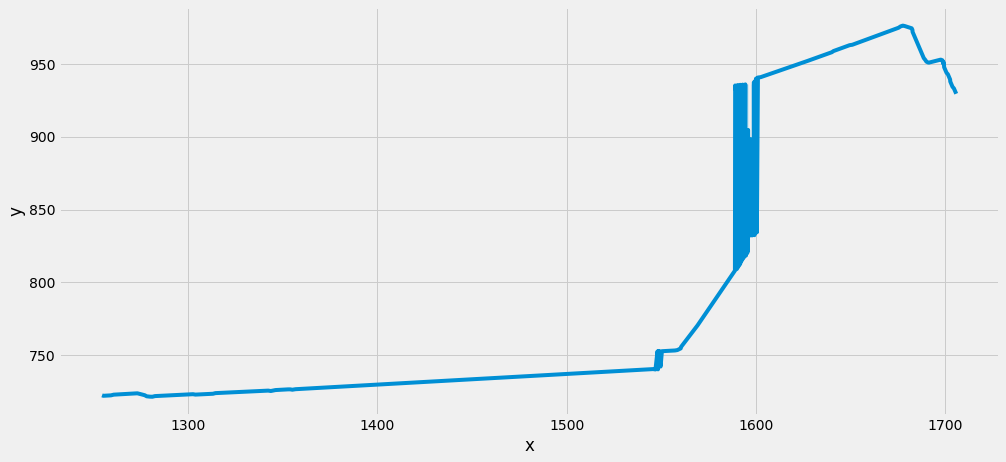

In [ ]:
sns.lineplot(x="x", y="y", data=ped0)

Split the pedestrian path into segments during which the pedestrian is walking in a straight line to make processing the data simpler

In [ ]:
# Get all points for which the angle is more than 5 degrees
# They represent turning points.
ped_data = output_data.drop(columns=["speed", "slope", "edge", "pos"])
ped_data.sort_values(by=["id", "time"], inplace=True)
ped_data = ped_data.reset_index(drop=True)
print(ped_data)
turning_condition = np.abs(ped_data["angle"].diff(1).fillna(0)) > 5
indices = ped_data.index[turning_condition].tolist()
indices.insert(0, 0)
indices.append(len(ped_data))

          time      id        x        y  angle
0          0.0    ped0  1254.41   722.40  85.74
1          1.0    ped0  1255.10   722.09  85.74
2          2.0    ped0  1256.36   722.19  85.56
3          3.0    ped0  1257.81   722.30  85.56
4          4.0    ped0  1259.13   722.40  85.73
...        ...     ...      ...      ...    ...
823311  4381.0  ped999  1231.16  1283.99  85.15
823312  4382.0  ped999  1232.51  1284.11  85.15
823313  4383.0  ped999  1234.02  1284.23  85.15
823314  4384.0  ped999  1235.65  1284.37  85.15
823315  4385.0  ped999  1237.16  1284.50  85.15

[823316 rows x 5 columns]


In [ ]:
# We then split the dataframe for the pedestrians at those turning points
# We do that by just add a number next to the id of the pedestrian to be able
# to differentiate each split from the others
count = defaultdict(int)
ped_data["id_segment"] = ""
for i in range(1, len(indices)):
    start = indices[i-1]
    end = indices[i]
    index = count[ped_data.loc[start, "id"]]
    count[ped_data.loc[start, "id"]] += 1
    ped_data.loc[start:end-1, "id_segment"] = ped_data.loc[start:end-1, "id"].apply(lambda x: x + "_{}".format(index))
    # ids = [ped_id + "_{}".format(index) for ped_id in ped_data.loc[start:end-1, "id"].values]
    # ped_data.loc[start:end-1, "id_segment"] = ids
print(ped_data)

          time      id        x        y  angle id_segment
0          0.0    ped0  1254.41   722.40  85.74     ped0_0
1          1.0    ped0  1255.10   722.09  85.74     ped0_0
2          2.0    ped0  1256.36   722.19  85.56     ped0_0
3          3.0    ped0  1257.81   722.30  85.56     ped0_0
4          4.0    ped0  1259.13   722.40  85.73     ped0_0
...        ...     ...      ...      ...    ...        ...
823311  4381.0  ped999  1231.16  1283.99  85.15  ped999_48
823312  4382.0  ped999  1232.51  1284.11  85.15  ped999_48
823313  4383.0  ped999  1234.02  1284.23  85.15  ped999_48
823314  4384.0  ped999  1235.65  1284.37  85.15  ped999_48
823315  4385.0  ped999  1237.16  1284.50  85.15  ped999_48

[823316 rows x 6 columns]


#### Stationarity

In [ ]:
ped00 = ped_data[ped_data["id_segment"] == "ped1_0"].copy(deep=True)
print(ped00)
# ped00["x"] = np.log(ped00["x"])
# ped00["y"] = np.log(ped00["y"])

      time    id        x        y   angle id_segment
512    4.0  ped1  1156.49  1458.43  176.55     ped1_0
513    5.0  ped1  1156.56  1457.29  176.55     ped1_0
514    6.0  ped1  1156.63  1456.18  176.55     ped1_0
515    7.0  ped1  1156.70  1455.02  176.45     ped1_0
516    8.0  ped1  1156.78  1453.72  176.45     ped1_0
..     ...   ...      ...      ...     ...        ...
654  146.0  ped1  1169.48  1290.89  174.67     ped1_0
655  147.0  ped1  1169.58  1289.76  174.67     ped1_0
656  148.0  ped1  1169.68  1288.67  174.67     ped1_0
657  149.0  ped1  1169.79  1287.53  174.67     ped1_0
658  150.0  ped1  1170.27  1286.26  174.67     ped1_0

[147 rows x 6 columns]


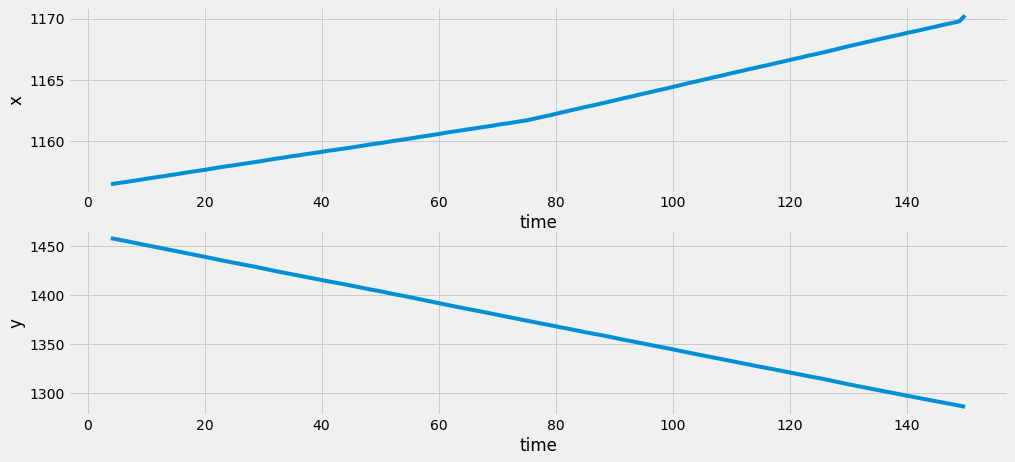

In [ ]:
f, axes = plt.subplots(2, 1)
sns.lineplot(x="time", y="x", data=ped00, ax=axes[0])
sns.lineplot(x="time", y="y", data=ped00, ax=axes[1])

In [ ]:
ped00["xdiff"] = ped00["x"].diff(1)
ped00["xdiff"].fillna(0, inplace=True)

In [ ]:
ped00["ydiff"] = ped00["y"].diff(1)
ped00["ydiff"].fillna(0, inplace=True)

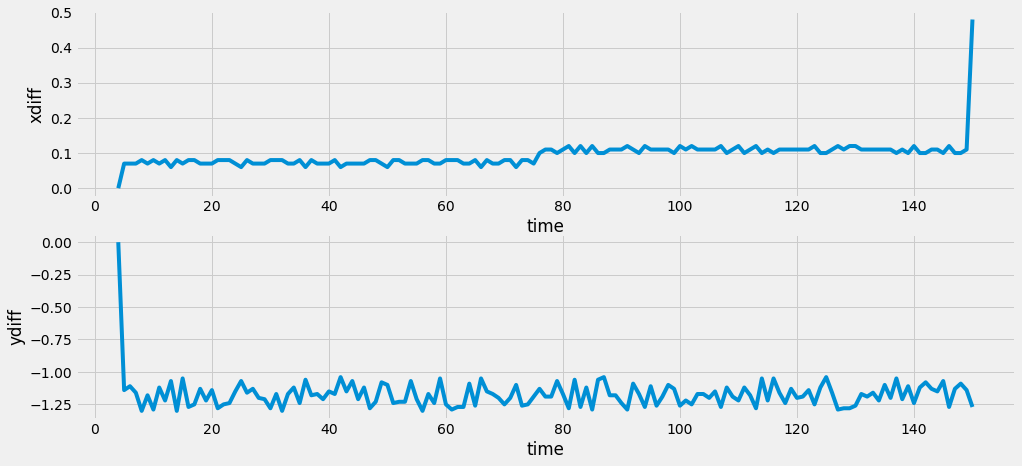

In [ ]:
f, axes = plt.subplots(2, 1)
sns.lineplot(x="time", y="xdiff", data=ped00, ax=axes[0])
sns.lineplot(x="time", y="ydiff", data=ped00, ax=axes[1])

## Training

In [ ]:
# We compute the first difference and normalize each segment separately
data_list = list()
max_length = 0
for _, segment in ped_data.groupby("id_segment"):
    segment = segment.copy(deep=True).reset_index(drop=True)
    # segment["x"] = np.log(segment["x"])
    # segment["y"] = np.log(segment["y"])
    segment["xdiff"] = segment["x"].diff(1)
    segment["xdiff"].fillna(0, inplace=True)
    segment["ydiff"] = segment["y"].diff(1)
    segment["ydiff"].fillna(0, inplace=True)
    data_input = segment[["xdiff","ydiff"]].values
    data_input = normalize(data_input, axis=0)
    data_input = np.reshape(data_input, (-1, 2))
    data_list.append(data_input)

In [ ]:
# We pad the sequences to the length of the longest segment so that we can concatenate them and process them in batches
# We use the value -25.0 to pad the sequences because it is unused and so can be masked easily
pad_value = -25.0
padded_data = pad_sequences(data_list, maxlen=None, dtype="float32", padding="post", value=pad_value)
print(padded_data.shape)

(38514, 362, 2)


In [ ]:
# We split the data into an input X and an output Y formed by delaying the input by one time step
X = padded_data[:, :-1, :]
Y = padded_data[:, 1:, :]
print(X.shape)
print(Y.shape)

(38514, 361, 2)
(38514, 361, 2)


In [ ]:
# The LSTM architecture
regressor = Sequential()
# Masking layer to mask
regressor.add(Masking(mask_value=pad_value, input_shape=(X.shape[1], X.shape[2])))
# LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True,))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=2))
print(regressor.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 361, 2)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 361, 50)           10600     
_________________________________________________________________
dropout (Dropout)            (None, 361, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 361, 2)            102       
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

In [ ]:
# Fitting to the training set
regressor.fit(X, Y, epochs=500, batch_size=16)

Epoch 1/500
2408/2408 [==============================] - 390s 160ms/step - loss: 1.5275
Epoch 2/500
2408/2408 [==============================] - 382s 159ms/step - loss: 1.1262
Epoch 3/500
2408/2408 [==============================] - 383s 159ms/step - loss: 0.9766
Epoch 4/500
2408/2408 [==============================] - 394s 164ms/step - loss: 0.8729
Epoch 5/500
2408/2408 [==============================] - 394s 163ms/step - loss: 0.8180
Epoch 6/500
2408/2408 [==============================] - 394s 163ms/step - loss: 0.7844
Epoch 7/500
2408/2408 [==============================] - 393s 163ms/step - loss: 0.7557
Epoch 8/500
2408/2408 [==============================] - 396s 164ms/step - loss: 0.7386
Epoch 9/500
2408/2408 [==============================] - 399s 166ms/step - loss: 0.7090
Epoch 10/500
2408/2408 [==============================] - 397s 165ms/step - loss: 0.6937
Epoch 11/500
2408/2408 [==============================] - 394s 164ms/step - loss: 0.6784
Epoch 12/500
2408/2408 [======

In [ ]:
predicted = regressor.predict(X[0:1])
mask = X[0:1] != -5.0
predicted = predicted[mask].reshape(1, -1, 2)
print(predicted)

[[[-0.1924711  -0.23096237]
  [-0.3269438  -0.45380038]
  [-0.19613889 -0.34801644]
  [-0.06487506 -0.23120707]
  [ 0.04048561 -0.12994644]
  [ 0.23773499  0.13957414]
  [ 0.18570714  0.08653447]
  [ 0.114195    0.01554939]
  [ 0.01824257 -0.08420032]
  [-0.12053305 -0.23371348]
  [-0.335078   -0.46530706]
  [-0.7232804  -0.87972724]
  [-1.578091   -1.7671742 ]
  [-3.8599057  -4.091867  ]
  [-6.297168   -6.5445848 ]]]


In [ ]:
true_value = Y[0:1][mask].reshape(1, -1, 2)
print(true_value)

[[[ 0.14698164 -0.4759104 ]
  [ 0.2498688   0.13816753]
  [ 0.2897638   0.16887143]
  [ 0.26036748  0.15351948]
  [ 0.2876641   0.7061896 ]
  [ 0.28556433  0.15351948]
  [ 0.256168    0.13816753]
  [ 0.2708662   0.15351948]
  [ 0.2834646   0.15351948]
  [ 0.28136486  0.15351948]
  [ 0.26876643  0.13816753]
  [ 0.2498688   0.13816753]
  [ 0.28556433  0.15351948]
  [ 0.29186356  0.16887143]
  [-5.         -5.        ]]]


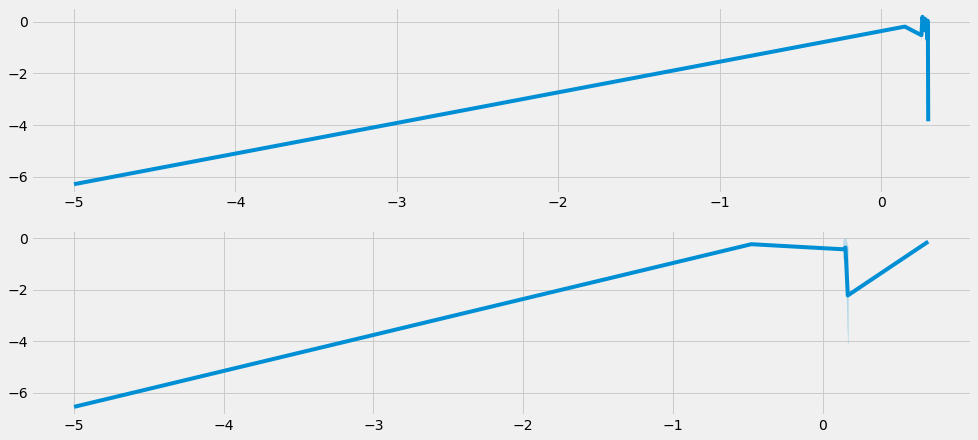

In [ ]:
f, axes = plt.subplots(2, 1)
sns.lineplot(x=true_value[0, :, 0], y=true_value[0, :, 1], ax=axes[0])
sns.lineplot(x=predicted[0, :, 0], y=predicted[0, :, 1], ax=axes[1])